In [ ]:
from datetime import datetime
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

import typing as tp
from sklearn.ensemble import RandomForestRegressor

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

sns.set(palette='Set2', font_scale=1.3)
from warnings import filterwarnings
filterwarnings('ignore')

# Сведение задачи прогнозирования временного ряда к регрессии

## 1. Различные ML модели 

## 1.1 Задача
Рассмотрим [датасет](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) с kaggle соревнования по прогнозированию спроса на товары. Это довольно простой и чистый датасет. Попробуем на нем разные подходы к прогнозированию временных рядов. Данные можно скачать [здесь](https://drive.google.com/file/d/1sZ2GmRUUwBg60ZSWt6cQWeOXe2HAvDxR/view?usp=share_link)

Данные содержат следующие колонки: 
* date &mdash; дата;
* store &mdash; ID магазина;
* item &mdash; ID товара;
* sales &mdash; количество продаж.

В датасете содержится информация про 50 товаров в 10 магазинах за 5 лет.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
DATA_PATH = '/content/drive/MyDrive/demand-forecasting-kernels-only.zip'
! unzip $DATA_PATH

Archive:  /content/drive/MyDrive/demand-forecasting-kernels-only.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
data = pd.read_csv('train.csv', parse_dates=['date'])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Как мы видим, датасет содержит информацию о магазинах, товарах и продажах. Выберем первый магазин и первый товар и будем предсказывать спрос на выбранный товар в данном магазине, используя последний год для сравнения моделей.

Выделим соотвествущие данные из датасета.

In [ ]:
# Задаем магазин и продукт
store, item = 1, 1

# Выделяем только те данные, которые относятся к данному магазину и продукту
data = data[(data['store'] == store) & (data['item'] == item)]

# ВНИМАНИЕ: Дату уставнавливаем как индекс
data = data.set_index('date')

# Выделяем данные о продажах
data = data['sales']

In [ ]:
data.shape

(1826,)

## **Задание** 1.2 Подготовка данных
Разделите данные на трейн и тест для обучения и тестирования результатов соотвественно. На тест отправьте данные за последний год, т.е. последние 365 элементов.Текст, выделенный полужирным шрифтом

In [ ]:
test_size = 365
data_train = data[:-test_size]
data_test  = data[-test_size:]

Визуализируйте полученные данные. Визуализировать данные нужно с самого начала. Это помогает провалидировать данные и выделить некоторые закономерности.

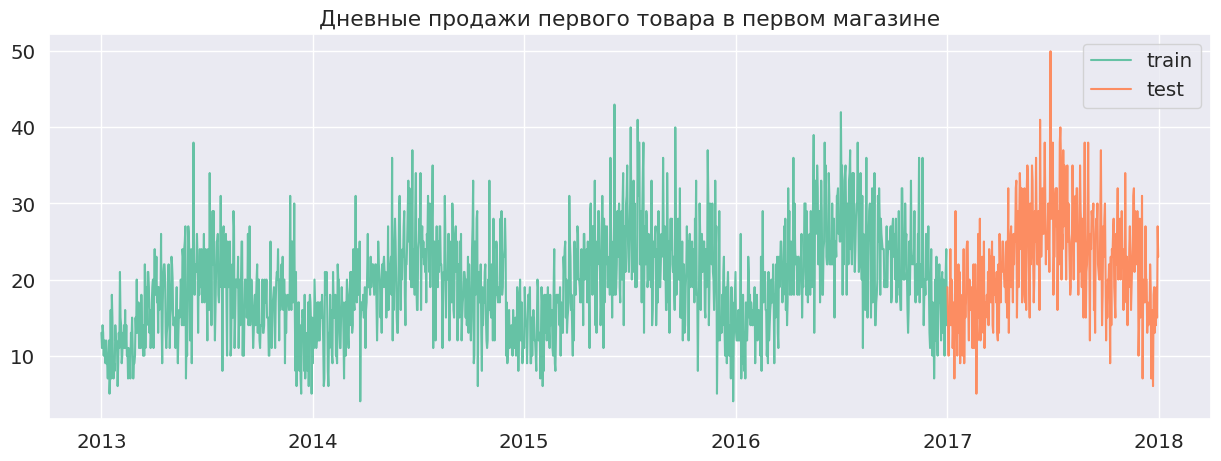

In [ ]:
plt.figure(figsize=(15, 5))
plt.title('Дневные продажи первого товара в первом магазине')
plt.plot(data_train, label='train')
plt.plot(data_test, label='test')
plt.legend();

Видите ли вы какую-нибудь зависимость? В продажах можно заметить некую переиодичность (наверно, товар сезонный). Также видно, что с каждым годом среднее кол-во продаж товара немного увеличивается

## **Задание** 1.3 Метрики
Теперь вернемся к самой задаче. Прежде чем ее решать, зададим метрики, по которым мы будем определять, какая из моделей лучше: MSE, MAE, MAPE. Допишите функцию, которая будет считать качество моделей.

Используйте функции из `sklearn.metrics`

In [ ]:
compare_table = None


def add_results_in_comparison_table(method: str, y_true, y_forecast) -> pd.DataFrame:
    """
    Добавляет новую строчку в таблицу compare_table с результатами текущей модели.
    Если ранее модель была уже добавлена в таблицу, то старая строчка перезапишется на новую.
    
    Параметры:
    - method: имя модели.
    - y_true: истинные значения.
    - y_forecast: предсказанные значения.
    """
    
    # Обращаемся к глобальной переменной
    global compare_table
    
    # Считаем метрики
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true, y_forecast),
        "MAE": mean_absolute_error(y_true, y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true, y_forecast)
    }
    
    # Записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table

## **Задание** 1.4 Простая модель / baseline
Для начала сделаем некоторую эмпирическую модель. Она будет считать среднее за каждый год с учетом дней недели. Полученное среднее как раз будет являться прогнозом на будущее.

In [ ]:
temp_data = pd.DataFrame(data_train)
# выделяем день недели
temp_data['weekofyear'] = data_train.index.weekofyear
temp_data['dayofweek'] = data_train.index.dayofweek
# считаем среднее за каждый год с учетом дня недели
mean_sales = temp_data.groupby(['weekofyear', 'dayofweek'])['sales'].mean()
display(mean_sales)

simple_prediction = []
for index in data_test.index:
    simple_prediction.append(mean_sales.loc[(index.weekofyear, index.dayofweek)])

weekofyear  dayofweek
1           0             8.666667
            1            12.750000
            2            12.000000
            3            12.750000
            4            13.750000
                           ...    
53          2            15.000000
            3            18.000000
            4            21.000000
            5            13.000000
            6            12.000000
Name: sales, Length: 371, dtype: float64

Допишите функцию для реализации результатов.

In [ ]:
def plot_results(y_to_train, y_to_test, y_forecast):
    """
        Функция для визуализации временного ряда и предсказания.
        
        Параметры:
            - y_to_train: pd.Series
                Временной ряд, на котором обучалась модель.
            - y_to_test: pd.Series
                Временной ряд, который предсказывает модель.
            - y_forecast: array
                Предсказания модели.
            - plot_conf_int: bool 
                Надо ли строить предсказательного интервал.
            - left_bound: array
                Левая граница предсказательного интервала.
            - right_bound: array
                Правая граница предсказательного интервала.
    """

    plt.figure(figsize=(15, 5))
    plt.title('Дневные продажи объекта 1 в магазине 1', fontsize=15)
    plt.plot(y_to_train, label='train')
    plt.plot(y_to_test, label='test')
    plt.plot(y_to_test.index, y_forecast, label='prediction')
    plt.legend()
    plt.show()

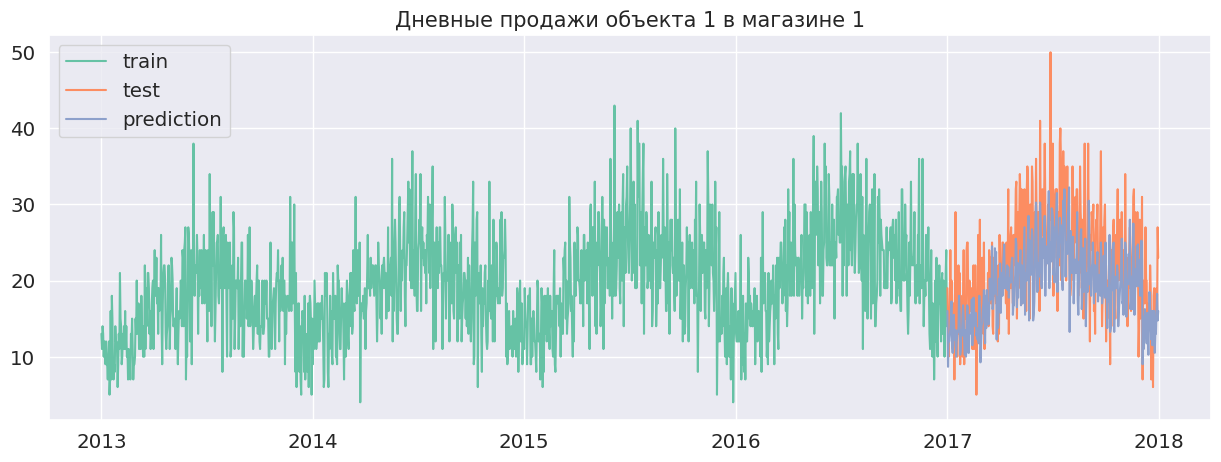

In [ ]:
plot_results(data_train, data_test, simple_prediction)

Хорошо ли выглядит результат?

Для простой модели выглядит очень даже неплохо. Посчитаем метрики и сохраним результат.

In [ ]:
add_results_in_comparison_table('Simple mean model', data_test, simple_prediction)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949


## **Задание** 1.5 Работа с признаками 1
Далее мы обучим с страндартную модель регрессии. Для начала научимся извлекать признаки из дат.

Вспомним, что мы установили дату индексом датафрейма, причем дата была распознана при считывании датасета с помощью параметра `parse_dates`

In [ ]:
data_train.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=1461, freq=None)

In [ ]:
idx = data_train.index[0]
idx

Timestamp('2013-01-01 00:00:00')

Видим, индекс датафрейма (`data_train.index`) эквивалентен списку, а его элементами являются объекты типа `Timestamp`. Для таких объектов можно сразу извлекать различные части дат. Пример:

In [ ]:
idx.year, idx.month, idx.day

(2013, 1, 1)

Для начала преобразуем дату, выделив из даты день, месяц, год и т.д. Для этого допишите функцию ниже. Почти для всех ключей названия атрибутов совпадают.

In [ ]:
def create_date_features(date):
    """Создает фичи из даты"""
    
    row = {}
    row['dayofweek'] = date.dayofweek
    row['quarter'] = date.quarter
    row['month'] = date.month
    row['year'] = date.year
    row['dayofyear'] = date.dayofyear
    row['dayofmonth'] = date.day
    row['weekofyear'] = date.weekofyear
    return row

С помощью следующей функции создадим датасет для обучения.

In [ ]:
def create_only_date_train_features(y_series):
    """
        Создает обучающий датасет из признаков, полученных из дат для y_series
    """
    
    time_features = pd.DataFrame([create_date_features(date) for date in y_series.index])
    return time_features, y_series

In [ ]:
X_train, y_train = create_only_date_train_features(data_train)
display(X_train.head())
display(y_train.head())

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1,1,1,2013,1,1,1
1,2,1,1,2013,2,2,1
2,3,1,1,2013,3,3,1
3,4,1,1,2013,4,4,1
4,5,1,1,2013,5,5,1


date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
Name: sales, dtype: int64

## **Задание** 1.5 Работа с признаками 2

Поработаем еще с признаками. На этот раз добавим сдвиги по времени. Таким образом модель сможет использовать информацию из прошлого, для составления прогноза на будущее.

В библиотеке pandas удобным образом реализованы сдвиги методом `shift` у датафреймов. Посмотрим как он работает

In [ ]:
sample = data_train[:10]
sample

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
2013-01-06    12
2013-01-07    10
2013-01-08     9
2013-01-09    12
2013-01-10     9
Name: sales, dtype: int64

Теперь применим сдвиг

In [ ]:
sample.shift(1, axis=0)

date
2013-01-01     NaN
2013-01-02    13.0
2013-01-03    11.0
2013-01-04    14.0
2013-01-05    13.0
2013-01-06    10.0
2013-01-07    12.0
2013-01-08    10.0
2013-01-09     9.0
2013-01-10    12.0
Name: sales, dtype: float64

Видно, что значения во втором столбце сдвинулись на единицу, причем в данных образовались пропуски, поскольку для начального значения предыдущего нет. Допишите функцию для создания данных со сдвигом. Помните, что у нас данные поступают каждый день, то есть сдвиг на 1 отвечает сдвигу на 1 день, сдвиг 7 отвечает сдвигу на 1 неделю, сдвиг на 365 отвечает сдвигу на год.

In [ ]:
def create_date_and_shifted_train_features(
    y_series, shifts=5, week_seasonal_shifts=1, year_seasonal_shifts=1
):
    """
    Создает обучающий датасет из признаков, полученных из дат и значений ряда ранее.
    При этом используются значения ряда со сдвигами на неделю и год назад.
    Параметры:
        - y_series
            временной ряд.
        - shifts
            дневной сдвиг (сколько дней учитываем).
        - week_seasonal_shifts
            недельный сдвиг (сколько недель учитываем).
        - year_seasonal_shifts
            годовой сдвиг (сколько лет учитываем).
    """
    
    curr_df, y = create_only_date_train_features(y_series)
    curr_df.index = y_series.index

    # применяем сдвиг по дням
    for shift in range(1, shifts + 1):
        curr_df[f'shift_{shift}'] = y_series.shift(shift, axis=0)

    # применяем сдвиг по неделям
    for shift in range(1, week_seasonal_shifts + 1):
        curr_df[f'week_seasonal_shift_{shift}'] = y_series.shift(shift*7, axis=0)
    
    # применяем сдвиг по годам
    for shift in range(1, year_seasonal_shifts + 1):
        curr_df[f'year_seasonal_shift_{shift}'] = y_series.shift(shift*365, axis=0)
    y = y_series
    
    # удалим первые строчки с nan
    drop_indices = curr_df.index[curr_df.isna().sum(axis=1) > 0]
    curr_df = curr_df.drop(index=drop_indices)
    y = y.drop(index=drop_indices)
    return curr_df, y

*Также* зададим функцию для того, чтобы получать аналогичные признаки на тесте.

In [ ]:
def date_and_shift_features_generator_for_test(date, previous_y):
    """Функция создания признаков из дат исдвигов ряда для тестовых дат"""
    
    row = create_date_features(date)
    for shift in range(1, SHIFT + 1):
        row[f'shift_{shift}'] = previous_y[-1 * shift]
    for shift in range(1, WEEK_SHIFT + 1):
        row[f'week_seasonal_shift_{shift}'] = previous_y[-1 * shift * 7]
    for shift in range(1, YEAR_SHIFT + 1):
        row[f'year_seasonal_shift_{shift}'] = previous_y[-1 * shift * 365]
    return row

Зададим сами сдвиги.

In [ ]:
SHIFT = 5       # дневной сдвиг
WEEK_SHIFT = 2  # недельный сдвиг
YEAR_SHIFT = 1  # годовой сдвиг

Получим новые признаки.

In [ ]:
X_train, y_train = create_date_and_shifted_train_features(
    data_train, 
    shifts=SHIFT, 
    week_seasonal_shifts=WEEK_SHIFT,
    year_seasonal_shifts=YEAR_SHIFT
)

In [ ]:
X_train.head(5)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,shift_1,shift_2,shift_3,shift_4,shift_5,week_seasonal_shift_1,week_seasonal_shift_2,year_seasonal_shift_1
date,,,,,,,,,,,,,,,
2014-01-01,2,1,1,2014,1,1,1,15.0,5.0,14.0,17.0,18.0,6.0,18.0,13.0
2014-01-02,3,1,1,2014,2,2,1,9.0,15.0,5.0,14.0,17.0,16.0,7.0,11.0
2014-01-03,4,1,1,2014,3,3,1,14.0,9.0,15.0,5.0,14.0,18.0,13.0,14.0
2014-01-04,5,1,1,2014,4,4,1,11.0,14.0,9.0,15.0,5.0,17.0,11.0,13.0
2014-01-05,6,1,1,2014,5,5,1,20.0,11.0,14.0,9.0,15.0,14.0,9.0,10.0


## **Задание** 1.6 Реализация рекурсивной стратегии

Реализуйте рекурсивную стратегию предсказания моделью.

In [ ]:
def recursive_prediction(model, test_dates, y_to_train, features_creation_function):
    """
    Функция для рекурсивного предсказания для дат, указанных в test_dates.
    
    Параметры:
        - model
            МЛ-модель.
        - test_dates
            массив с датами, в которые надо сделать предсказания.
        - features_creation_function
            функция для создания тестовых признаков
    """
    predictions = []
    previous_y = list(y_to_train)
    
    for date in test_dates:

        # получаем признаки для тестовых данных из тестовой даты и предыдущих значений
        row = features_creation_function(date, previous_y)
        curr_test = pd.DataFrame([row])

        # выоплняем предсказание моделью
        curr_prediction = model.predict(curr_test)[0]

        # добавляем текущее предсказание к предыдущем значениям
        previous_y.append(curr_prediction)
        # сохраняем текущее предсказание для вердикта на тесте
        predictions.append(curr_prediction)
    return np.array(predictions)

Посмотрим, как пользоваться нашими функциями на примере модели случайного леса `RandomForest` и двух видов признаков (даты, даты + предыдущие значения)

Подготовка данных

In [ ]:
X_train, y_train = create_only_date_train_features(data_train)

# Если мы хотим использовать и сдвинутые значения, данные готовятся так

# X_train, y_train = create_date_and_shifted_train_features(
#     data_train, 
#     shifts=SHIFT, 
#     week_seasonal_shifts=WEEK_SHIFT,
#     year_seasonal_shifts=YEAR_SHIFT
# )

Обучим модель на признаках из дат

In [ ]:
%%time
random_forest = RandomForestRegressor(n_estimators=300)
random_forest.fit(X_train, y_train)

CPU times: user 2.33 s, sys: 7.3 ms, total: 2.34 s
Wall time: 3.68 s


RandomForestRegressor(n_estimators=300)

Получим предсказания. В данном случае для функции `recursive_prediction` в качестве аргумента `features_creation_function` нужно использовать функцию, создающие признаки из дат, предыдущие значения в данном случае не нужны. Однако в функции выше мы использовали в качестве аргументов и даты, и предыдущие значения, поэтому нам понадобится конструкция 

`lambda date, previous_y: create_date_features(date)`

которая задаст функцию уже от двух аргументов.

In [ ]:
random_forest_predictions = recursive_prediction(
    random_forest, data_test.index, data_train, 
    lambda date, previous_y: create_date_features(date)
)

Для дополнительного использования сдвинутых дат в эту функцию в качестве последнего аргумента нужно подавать функцию `date_and_shift_features_generator_for_test`, определенную выше.

А для подготовки данных нужно использовать функцию `create_date_and_shifted_train_features`.

## **Задание** 1.7 Обучение классической модели

Обучите модель `RandomForest` на двух видах признаков. Визуализируйте результаты в каждом случае и добавляйте метрики в таблицу.

---

Используем только даты

In [ ]:
X_train, y_train = create_only_date_train_features(data_train)

random_forest = RandomForestRegressor(n_estimators=300)
random_forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [ ]:
random_forest_predictions = recursive_prediction(
    random_forest, data_test.index, data_train, 
    lambda date, previous_y: create_date_features(date)
)

Отобразим результаты.

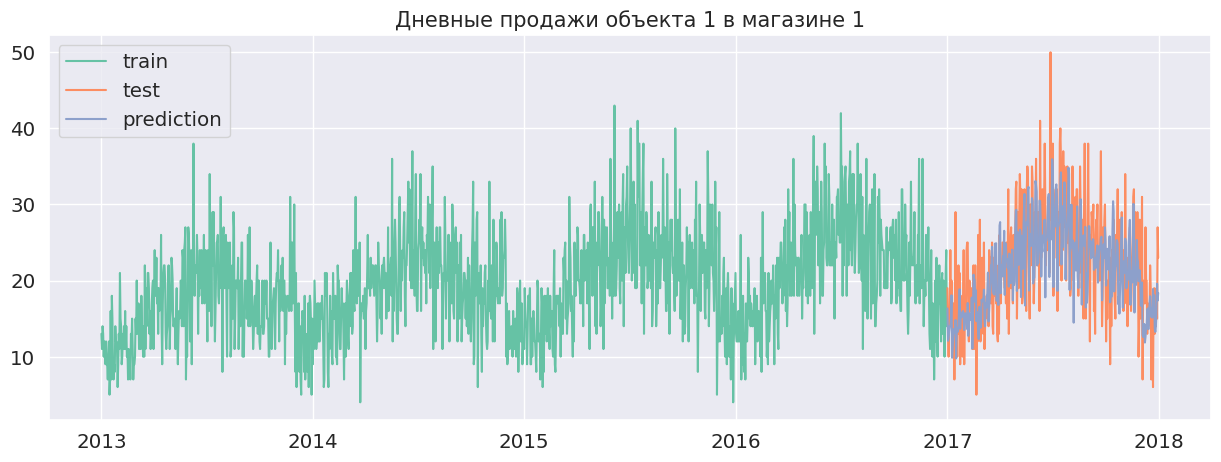

In [ ]:
plot_results(data_train, data_test, random_forest_predictions)

Посчитаем метрики

In [ ]:
add_results_in_comparison_table('RandomForest', data_test, random_forest_predictions)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.084511,4.175918,0.212206


---- 

Используем дополнительно сдвинутые признаки

In [ ]:
X_train, y_train = create_date_and_shifted_train_features(data_train, shifts=SHIFT, week_seasonal_shifts=WEEK_SHIFT, year_seasonal_shifts=YEAR_SHIFT)

random_forest = RandomForestRegressor(n_estimators=300)
random_forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [ ]:
random_forest_predictions = recursive_prediction(
    random_forest, data_test.index, data_train, 
    date_and_shift_features_generator_for_test
)

Отобразим результаты

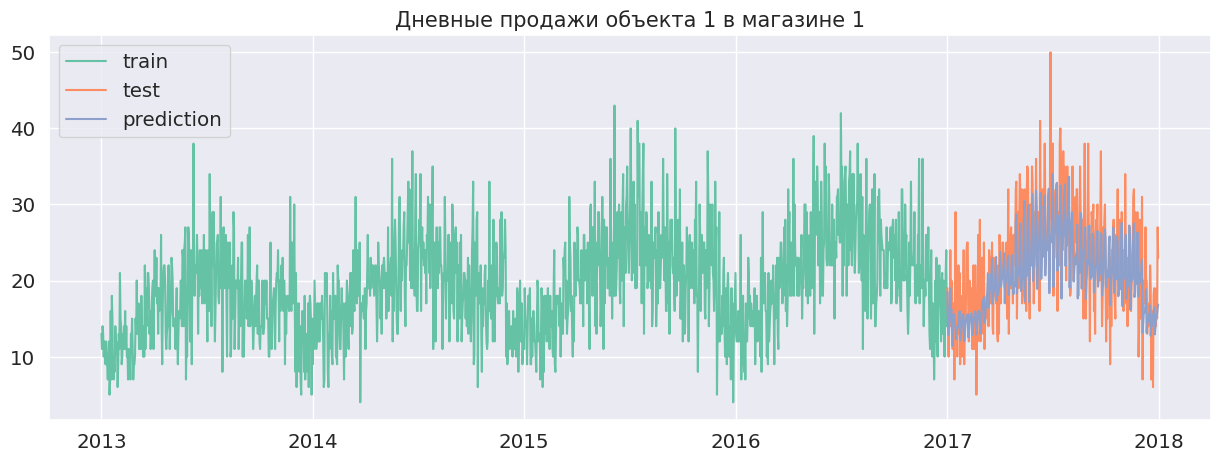

In [ ]:
plot_results(data_train, data_test, random_forest_predictions)

Посчитаем метрики.

In [ ]:
add_results_in_comparison_table('RandomForest+shifted features', data_test, random_forest_predictions)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.084511,4.175918,0.212206
2,RandomForest+shifted features,25.991229,4.031808,0.195645


**Вывод:** После того, как мы применили random forest к модели, а потом использовали shift с каждым разом мы получали всё лучшие результаты, об этом можно судить по таблице выше. Признаки, к которым мы применяли shift также можно видеть выше.

---

## 2. Обучение нейронных сетей

## **Задание** 2.1 `Conv1d`

В pytorch 1d свертка реализована в классе `nn.Conv1d`. Параметры у этого класса такие же, как у свертки 2d, однако на вход она ожидает уже трехмерный тензор вида `(batch_size, C_in, seq_len)`, где 
* `batch_size` - размер батча
* `seq_len` - длина последовательности
* `C_in` - число входных каналов, которое совпадает с размерностью каждого вектора в последовательности

Посмотрим, как она работает.

In [ ]:
import torch
import torch.nn as nn

In [ ]:
batch_size = 10
seq_len = 16
in_channels = 32

inp = torch.randn((batch_size, in_channels, seq_len))

In [ ]:
# параметры свертки
out_channels = 64
ksize = 5

conv = nn.Conv1d(in_channels, out_channels, ksize)
conv(inp).shape

torch.Size([10, 64, 12])

Для разных значений паддинга посмотрите на размерность выхода.

In [ ]:
for padding in range(5):
  conv = nn.Conv1d(in_channels, out_channels, ksize, padding=padding)
  print(padding, conv(inp).shape)

Для разных значений страйда посмотрите на размерность выхода

In [ ]:
for stride in range(1, 5):
  conv = nn.Conv1d(in_channels, out_channels, ksize, padding=2, stride=stride)
  print(stride, conv(inp).shape)

1 torch.Size([10, 64, 16])
2 torch.Size([10, 64, 8])
3 torch.Size([10, 64, 6])
4 torch.Size([10, 64, 4])


согласуются ли результаты с обычными свертками? Да, согласуются. Размер увеличивается с ростом padding и уменьшается с ростом stride

## **Задание** 2.2 

## Параметры и применение рекуррентных сетей

Перед тем, как использовать нейронные сети, вспомним, какие гиперпараметры у них есть и как следует их использовать.

![](https://cdn.shortpixel.ai/client/q_glossy,ret_img,w_1200/http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1200x361.png)

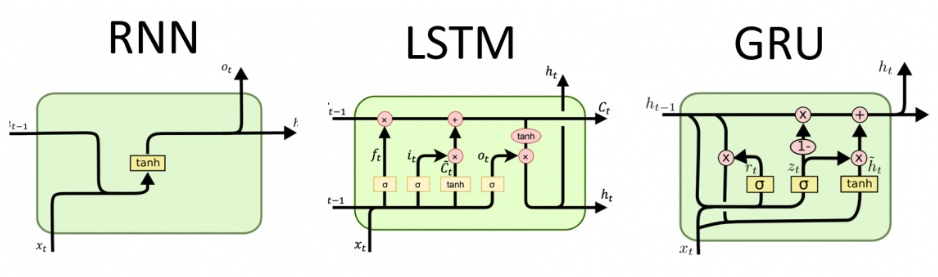

#### 1. Vanilla RNN

Клетка Vanilla RNN принимает на вход очередной элемент $x_t$ и предыдущее скрытое состояние $h_{t-1}$ и выдаёт новое скрытое состояние $h_t$. 

Преобразование происходит по формуле:

$$h_t = \sigma(U_hx_t + V_hh_{t-1} + b_h),$$

где
* $x_{t}$ &mdash; вектор размерности `[emb_dim, 1]`;

* $h_t, b_h$ &mdash; векторы размерности `[hid_dim, 1]`;

* $U_h$ &mdash; матрица размера `[emb_dim, hid_dim]`; 

* $V_h$ &mdash; матрица `[hid_dim, hid_dim]`, 

$U_h, V_h, b_h, W_y, b_y$ &mdash; обучаемые параметры RNN-клетки, а `hid_dim`, `emb_dim` &mdash; гиперпараметры.

Если же мы хотим решать задачу классификации, то мы можем применить линейный слой с функций softmax к скрытому состоянию и получить предсказание вероятности:
$$o_t = \sigma(W_o h_t + b_o).$$

В модуле `torch.nn` клетка Vanilla RNN представлена классом `torch.nn.RNNCell`. Его можноинициализировать следующим образом:

`torch.nn.RNNCell(input_size: int, hidden_size: int, bias: bool = True, nonlinearity: str = 'tanh')`. 

Класс `RNNCell` возвращает скрытое состояние $h_t$.

Самый простой пример применения клетки RNN:

In [ ]:
rnn = nn.RNNCell(input_size=10, hidden_size=20)
input = torch.randn(3, 10)
hx = torch.randn(3, 20)

hx = rnn(input, hx)
print(hx.shape)

torch.Size([3, 20])


Если на вход не подается hx (например, для первого элемента последовательности), вектор скрытых состояний считается нулевым

In [ ]:
hx = rnn(input)
print(hx.shape)

torch.Size([3, 20])


Напишите функцию для последовательного применения клетки RNNCell к последовательности векторов.

In [ ]:
def aply_rnncell_to_seq(rnn_cell, input, hx=None):
    """
    rnn_cell - клетка rnn 
    input - входной тензор размерности (seq_len, batch_size, input_size)
    hx - начальный вектор скрытого состяния

    возвращает: последнее скрытое состояние для каждого элемента батча
    """
  
    for i in range(len(input)):
        if hx is None:
          hx = rnn_cell(input[i])
        else:
          hx = rnn_cell(input[i], hx)
    return hx

In [ ]:
input = torch.randn(15, 3, 10)
rnn = nn.RNNCell(input_size=10, hidden_size=20)
hx = torch.randn(3, 20)

aply_rnncell_to_seq(rnn, input, hx).shape

torch.Size([3, 20])

In [ ]:
aply_rnncell_to_seq(rnn, input).shape

torch.Size([3, 20])

Каждый раз писать цикл, чтобы прогнать все элементы через `RNNCell`, нужно писать цикл, что совсем неудобно. А если мы хотим использовать ещё многослойные `RNN`, то неудобство возрастает. Для удобства существует класс `RNN`. Его параметры:

1. `input_size` — размер эмбеддинга;

2. `hidden_size` — размер скрытого состояния;

3. `num_layers` — число рекуррентных слоёв;

4. `nonlinearity` — функция активации — `'tanh'` или `'relu'`, по умолчанию: `'tanh'`;

5. `bias` – если установлен в `False`, то $b\_h$ устанавливаются равными 0 и не обучается, по умолчанию: `True`;

6. `batch_first` – если `True`, то входные и выходные тензоры имеют размерность `(batch, seq_len, feature)`, иначе `(seq_len, batch, feature)`, по умолчанию: `False`;

7. `dropout` – вероятность отключения каждого нейрона при dropout, по умолчанию: `0`;

8. `bidirectional` – использовать ли двунаправленную сеть.

\\

`RNN` возвращает `h_n` и `output`.

* `h_n` – скрытые состояния на последний момент времени со всех слоев и со всех направлений (forward и backward).
В случае, если слой один и RNN unidirectional, то это просто последнее скрытое состояние. Размерность `h_n`:  `(batch, num_layers * num_directions, hidden_size)`.

* `output` – скрытые состояния последнего слоя для всех моментов времени t. В случае, `bidirectional`=True, то то же самое и для обратного прохода.   Размерность `output`: `(batch, seq_len,num_directions * hidden_size)`.

Сначала для однослойной RNN

In [ ]:
seq_len = 5
batch = 3
input_size = 10
layers_num = 1
hidden_size = 20

rnn = nn.RNN(input_size=10, hidden_size=20, num_layers=layers_num)
input = torch.randn(seq_len, batch, input_size)
h0 = torch.randn(layers_num, batch, hidden_size)
output, hn = rnn(input, h0)
print(output.shape, hn.shape)

torch.Size([5, 3, 20]) torch.Size([1, 3, 20])


Теперь для многослойной.

In [ ]:
seq_len = 5
batch = 3
input_size = 10
layers_num = 7
hidden_size = 20

rnn = nn.RNN(input_size=10, hidden_size=20, num_layers=layers_num)
input = torch.randn(seq_len, batch, input_size)
h0 = torch.randn(layers_num, batch, hidden_size)
output, hn = rnn(input, h0)
print(output.shape, hn.shape)

torch.Size([5, 3, 20]) torch.Size([7, 3, 20])


Объясните, какие размерности чему соответствуют.
input_size соответствует размеру энбендинга, layers_num - число рекурентных слоёв, hidden_size - размер скрытого состояния.

---

#### 2. LSTM

Как выглядит LSTM и какие у неё обучаемые параметры, было рассказано на лекции. Поэтому сосредоточимся на работе с классами `pytorch`.
Устройство LSTM в `pytorch` аналогично Vanilla RNN. Основное отличие в параметрах &mdash; скрытое состояние представляет собой кортеж из двух векторов $(h_t, c_t)$. 

Для начала посмотрим на одну клетку.

In [ ]:
seq_len = 6

# инициализируем клетку lstm
lstm = nn.LSTMCell(10, 20)
# сгенерируем случайную последовательность чисел
input = torch.randn(seq_len, 3, 10)
hx, cx = torch.randn(3, 20), torch.randn(3, 20)

# пропустим сгенерированную последовательность через LSTM
for i in range(seq_len):
    hx, cx = lstm(input[i], (hx, cx))
print(hx.shape, cx.shape)

torch.Size([3, 20]) torch.Size([3, 20])


Аналогично происходит работа с полной LSTM. LSTM возвращает `output`, `h_n`, `c_n`, где `output` полностью аналогичен тому, что был у RNN, то есть является последовательностью из `h_t` для последнего слоя.

In [ ]:
seq_len = 5
batch = 3
input_size = 10
layers_num = 2
hidden_size = 20

lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2)
input = torch.randn(seq_len, batch, input_size)
h0 = torch.randn(layers_num, batch, hidden_size)
c0 = torch.randn(layers_num, batch, hidden_size)
output, (hn, cn) = lstm(input, (h0, c0))
print(output.shape, hn.shape, cn.shape)

torch.Size([5, 3, 20]) torch.Size([2, 3, 20]) torch.Size([2, 3, 20])


#### 3. GRU

Наборы параметров классов `GRUCell` и `GRU` и размерности возвращаемых тензоров совпадают соответсвенно с параметрами `RNNCell` и `RNN`. 


## **Задание** 2.3

**Обучение нейросети (сверточной и рекуррентной):**

Предположим мы хотим обучать нейросеть, используя $\tau$ предыдущих измерений. Тогда каждую эпоху мы будем передавать сети батчи из последовательных отрезков временного ряда с индексами от $t - \tau + 1$ до $t$ и для каждого такого отрезка будем просить предсказать значение с индектом $t + 1$, где $t$ &mdash; момент времени, $t > \tau - 1$.

Иначе говоря, нейронная сеть будет приближать функцию
$$X_{t-\tau+1}, ..., X_t \mapsto X_{t+1}.$$

**Вычисление предсказаний:**

* Возьмем $\tau$ последних обучающих данных и на их основе вычислим прогноз в первый момент времени тестового отрезка ряда. 
* Последующие прогнозы будем делать на основе предыдущих прогнозов, не используя значения из тестового отрезка ряда.

Вспомогательные функции для обучения.

In [ ]:
from IPython.display import clear_output
from collections import defaultdict
import time

def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации.
    '''

    fig = plt.figure(figsize=(10, 5))
    plt.plot(history['loss'])
    plt.ylabel('Лосс')
    plt.xlabel('Эпоха')
    plt.show()


def train_ts_model(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    num_epochs=50,
):
    '''
    Функция для обучения модели и вывода лосса во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) loss на обучении ('история' обучения)
    '''

    history = defaultdict(list)

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой 'эпохе' делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.type('torch.FloatTensor').to(device)
            y_batch = y_batch.type('torch.FloatTensor').to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())

        # Подсчитываем лосс и сохраням в 'историю'
        train_loss /= len(train_batch_gen)
        history['loss'].append(train_loss)

        clear_output()

        # Печатаем результаты после каждой эпохи
        print('Эпоха {} из {} выполнена за {:.3f} сек.'.format(
            epoch + 1, num_epochs, time.time() - start_time))
        print('  лосс: \t{:.6f}'.format(train_loss))
        plot_learning_curves(history)

    return model, history

Функция для рекуррентного предсказания сетью.

In [ ]:
def evaluate_ts_model(model, start_seq, test_data, return_all=False):
    '''
    Функция для проверки качества модели на обучающем отрезке ряда.

    :param model: обучаемая модель,
    :param start_seq: обучающие данные для первого предсказания,
    :param test_data: тестовые данные.
    :param return_all: возвращать все предсказания или только для 1-го магазина

    :return: результаты предсказания.
    '''
    result = []

    input_tensor = torch.FloatTensor(start_seq).to(device).unsqueeze(0)
    with torch.no_grad():
        for i in range(len(test_data)):
            logits = model(input_tensor[:, i:, :]).unsqueeze(0)
            input_tensor = torch.cat((input_tensor, logits), 1)
            result.append(logits.cpu().numpy().squeeze())
    if return_all:
      return np.array(result)
    return np.array(result)[:, 0]

Вернемся к данным. Нейронной сетью мы будем приближать функцию 

$$X_{t-\tau+1}, ..., X_t \mapsto X_{t+1}.$$

где $ X_t$ - некоторый вектора. В предыдущей части мы использовали данные по товару 1 только для 1 магазина. Однако обучать нейронку на векторах размера 1 не очень интересно, поэтому будем учить нейронную сеть предсказывать продажи товара 1 сразу для всех магазинов. 

На этапе тестирования (для магазина 1) для этой нейронки нужно брать только одну компоненту вектора (см. функцию выше).

Подготовим данные для обучения.

In [ ]:
data = pd.read_csv('train.csv', parse_dates=['date'])
data.head()

# Задаем продукт
item = 1

# Выделяем только те данные, которые относятся к данному продукту
data = data[data['item'] == item]

# ВНИМАНИЕ: Дату уставнавливаем как индекс
data = data.set_index('date')

Соберем в один dataframe продажи для всех магазинов

In [ ]:
processed_data = pd.DataFrame()
for store in data['store'].unique():
  processed_data[f'store_{store}_sales'] = data[(data['store'] == store) & (data['item'] == item)]['sales']

In [ ]:
processed_data.head()

,store_1_sales,store_2_sales,store_3_sales,store_4_sales,store_5_sales,store_6_sales,store_7_sales,store_8_sales,store_9_sales,store_10_sales
date,,,,,,,,,,
2013-01-01,13,12,19,10,11,20,7,16,11,14
2013-01-02,11,16,8,12,9,6,4,10,9,14
2013-01-03,14,16,10,8,12,11,8,12,20,16
2013-01-04,13,20,15,15,8,7,7,21,22,17
2013-01-05,10,16,22,19,13,12,8,15,22,12


Проверим, что количество дат совпадает с прошлым разом.

In [ ]:
processed_data.shape

(1826, 10)

Разделим на трейн и тест, как и раньше.

In [ ]:
processed_data_train = processed_data.iloc[:-test_size]
processed_data_test = processed_data.iloc[-test_size:]

Для обучения нужно создать датасет, который будет возвращать последовательность из $\tau$ элементов временного ряда для обучения и следующий за ними $(\tau+1)$-элемент как таргет. Для этого мы создадим класс-наследник от класса `Dataset` из [`torch.utils.data`](https://pytorch.org/docs/stable/data.html).

При наследовании от `Dataset` необходимо переопределить `__len__` и `__getitem__`.

In [ ]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, n_past):
        self.data = data
        self.n_past = n_past  # tau -- длина отрезка временого ряда

    def __len__(self):
        return self.data.shape[0] - self.n_past

    def __getitem__(self, index):
        return self.data[index: self.n_past + index], self.data[self.n_past + index]

### **Задание** 2.3.1. Сверточная сеть

Определим простую сверточную сеть для предсказания следующего элемента.

In [ ]:
class Conv1dModel(nn.Module):
    def __init__(self, in_channels, output_size):
        super().__init__()

        self.conv1 = nn.Conv1d(
            in_channels, out_channels=32, kernel_size=30, stride=2)
        self.bn1 = nn.BatchNorm1d(num_features=32)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(
            in_channels=32, out_channels=64, kernel_size=8, stride=2)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(
            in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.relu3 = nn.ReLU()
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        # вместо global pooling можно использовать flatten, но тогда линейный слой будет сильно завязан на размер последовательности
        # self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=128, out_features=128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=output_size)

    def forward(self, input_seq):
        # input_seq.shape = [bs, seq_len, 10]

        # input_seq.shape = [bs, 10, seq_len]
        input_seq = input_seq.transpose(1, 2)

        # x.shape = [bs, 32, seq_len_1]
        x = self.relu1(self.bn1(self.conv1(input_seq)))

        # x.shape = [bs, 64, seq_len_2]
        x = self.relu2(self.bn2(self.conv2(x)))

        # x.shape = [bs, 128, seq_len_3]
        x = self.relu3(self.bn3(self.conv3(x)))

        # x.shape = [bs, 128]
        x = self.pool(x).squeeze(2)

        # x.shape = [bs, 128]
        x = self.relu(self.fc1(x))

        # x.shape = [bs, 2]
        x = self.fc2(x)
        return x

### **Задание** 2.3.1. Сверточная сеть

Определим простую сверточную сеть для предсказания следующего элемента.

In [ ]:
class Conv1dModel(nn.Module):
    def __init__(self, in_channels, output_size):
        super().__init__()

        self.conv1 = nn.Conv1d(
            in_channels, out_channels=32, kernel_size=30, stride=2)
        self.bn1 = nn.BatchNorm1d(num_features=32)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(
            in_channels=32, out_channels=64, kernel_size=8, stride=2)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(
            in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.relu3 = nn.ReLU()
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        # вместо global pooling можно использовать flatten, но тогда линейный слой будет сильно завязан на размер последовательности
        # self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=128, out_features=128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=output_size)

    def forward(self, input_seq):
        # input_seq.shape = [bs, seq_len, 10]

        # input_seq.shape = [bs, 10, seq_len]
        input_seq = input_seq.transpose(1, 2)

        # x.shape = [bs, 32, seq_len_1]
        x = self.relu1(self.bn1(self.conv1(input_seq)))

        # x.shape = [bs, 64, seq_len_2]
        x = self.relu2(self.bn2(self.conv2(x)))

        # x.shape = [bs, 128, seq_len_3]
        x = self.relu3(self.bn3(self.conv3(x)))

        # x.shape = [bs, 128]
        x = self.pool(x).squeeze(2)

        # x.shape = [bs, 128]
        x = self.relu(self.fc1(x))

        # x.shape = [bs, 2]
        x = self.fc2(x)
        return x

Заметим, что у нас в данных есть явно два вида колебаний: с большим периодом около года и более быстрые, поэтому брать tau слишком маленьким (в районе недели) бессмысленно. Поставим сначала большую длину отрезка временного ряда.

In [ ]:
n_past = 120  # tau -- длина отрезка временого ряда
batch_size = 64  # размер батча

train_dataset = TSDataset(processed_data_train.to_numpy(), n_past)
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)

In [ ]:
device = 'cpu'

In [ ]:
model = Conv1dModel(10, 10)

criterion = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

Эпоха 50 из 50 выполнена за 0.767 сек.
  лосс: 	22.134704


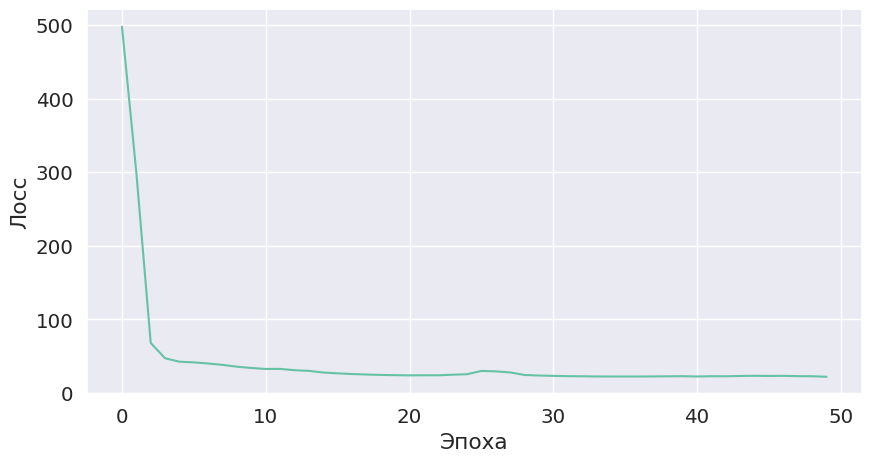

In [ ]:
model, _ = train_ts_model(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    num_epochs=50,
)

In [ ]:
model.eval()
start_seq = processed_data_train[-n_past:].to_numpy()
result = evaluate_ts_model(model, start_seq, processed_data_test)

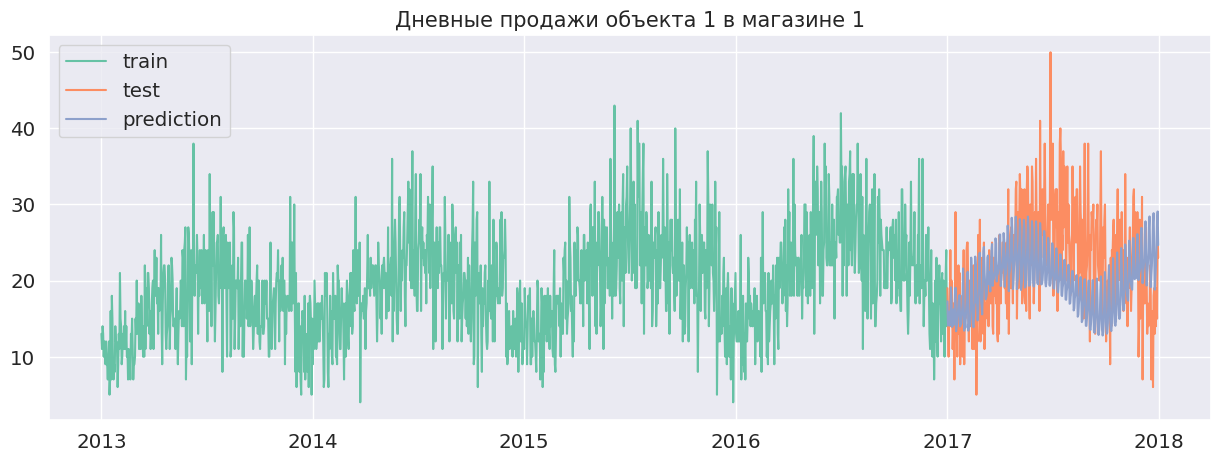

In [ ]:
plot_results(data_train, data_test, result)

In [ ]:
add_results_in_comparison_table('Conv1d+data_from_other_stores+120_window', data_test, result)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.084511,4.175918,0.212206
2,RandomForest+shifted features,25.991229,4.031808,0.195645
3,Conv1d+data_from_other_stores+120_window,49.259769,5.550029,0.271758


Теперь возьмем окно в 2 раза меньше, то есть 2 месяца.

In [ ]:
n_past = 60  # tau -- длина отрезка временого ряда
batch_size = 64  # размер батча

train_dataset = TSDataset(processed_data_train.to_numpy(), n_past)
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)

In [ ]:
model = Conv1dModel(10, 10)

criterion = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

Эпоха 50 из 50 выполнена за 0.295 сек.
  лосс: 	19.866289


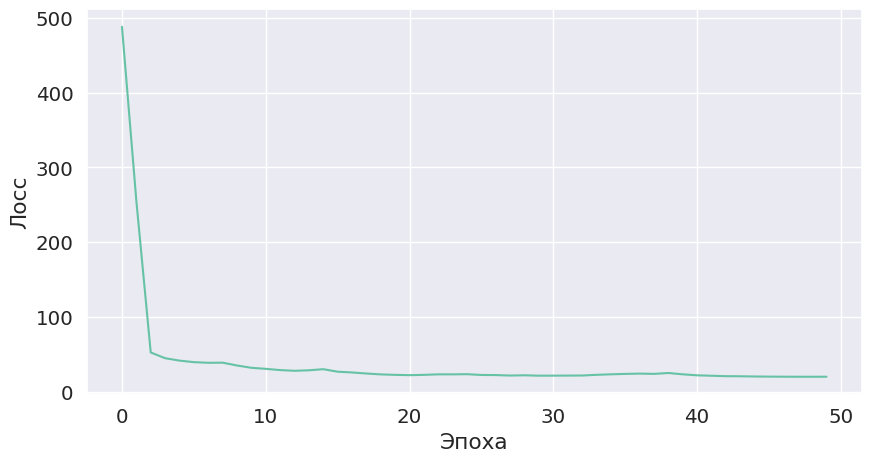

In [ ]:
model, _ = train_ts_model(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    num_epochs=50,
)

In [ ]:
model.eval()
start_seq = processed_data_train[-n_past:].to_numpy()
result = evaluate_ts_model(model, start_seq, processed_data_test)

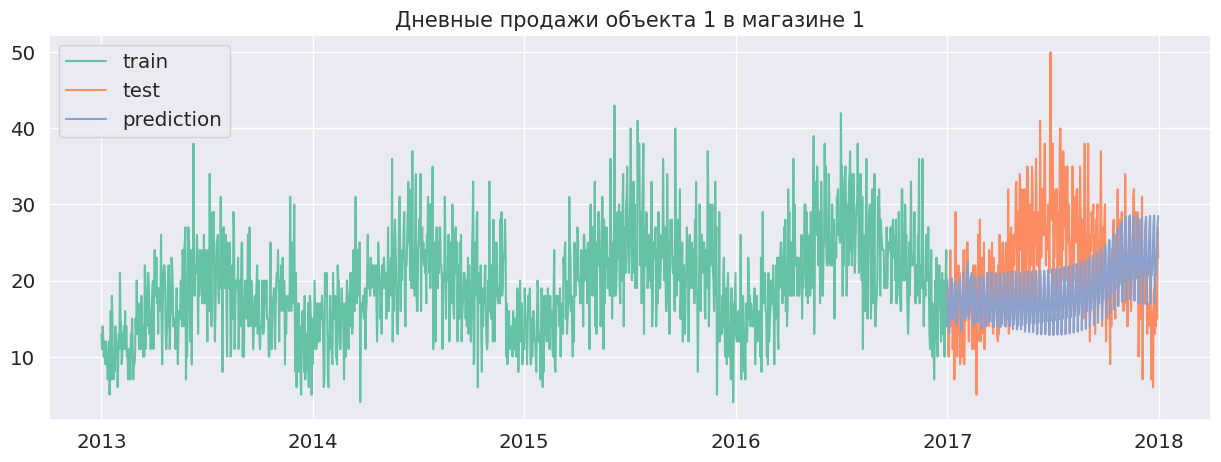

In [ ]:
plot_results(data_train, data_test, result)

In [ ]:
add_results_in_comparison_table('Conv1d+data_from_other_stores+60_window', data_test, result)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.084511,4.175918,0.212206
2,RandomForest+shifted features,25.991229,4.031808,0.195645
3,Conv1d+data_from_other_stores+120_window,49.259769,5.550029,0.271758
4,Conv1d+data_from_other_stores+60_window,60.461322,6.217035,0.290826


И наконец, возьмем годовое окно.

In [ ]:
n_past = 365  # tau -- длина отрезка временого ряда
batch_size = 64  # размер батча

train_dataset = TSDataset(processed_data_train.to_numpy(), n_past)
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)

In [ ]:
model = Conv1dModel(10, 10)

criterion = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

Эпоха 50 из 50 выполнена за 1.629 сек.
  лосс: 	31.409313


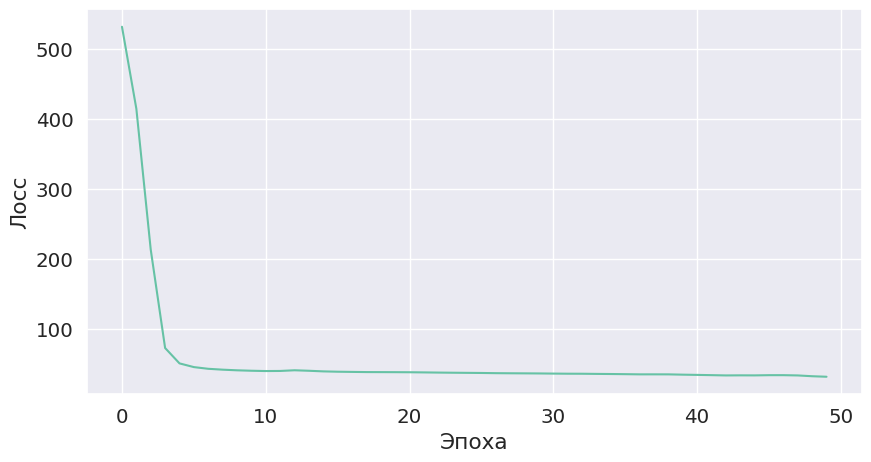

In [ ]:
model, _ = train_ts_model(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    num_epochs=50,
)

In [ ]:
model.eval()
start_seq = processed_data_train[-n_past:].to_numpy()
result = evaluate_ts_model(model, start_seq, processed_data_test)

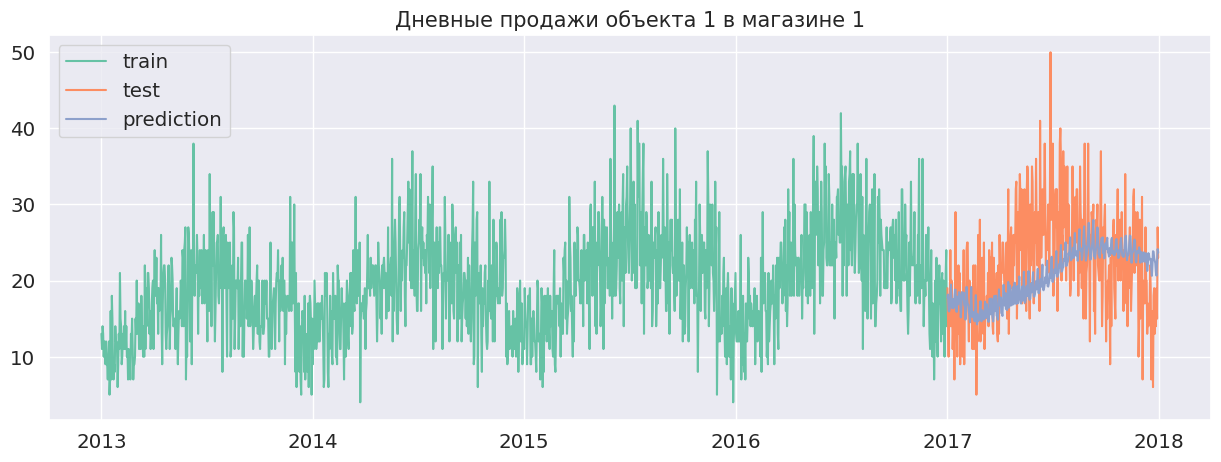

In [ ]:
plot_results(data_train, data_test, result)

In [ ]:
add_results_in_comparison_table('Conv1d+data_from_other_stores+365_window', data_test, result)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.084511,4.175918,0.212206
2,RandomForest+shifted features,25.991229,4.031808,0.195645
3,Conv1d+data_from_other_stores+120_window,49.259769,5.550029,0.271758
4,Conv1d+data_from_other_stores+60_window,60.461322,6.217035,0.290826
5,Conv1d+data_from_other_stores+365_window,48.989193,5.450387,0.271807


Сделайте вывод, какая из моделей как ведет себя на различных временных промежутках и на различных колебаниях.

**ваш ответ** +- хорошо свёртка работает на 2 месяцах, но нигде не предсказан пик

На основании данных графиков сделайте вывод о преимуществах и недостатках рекурсивной стратегии, а также об идее иметь несколько моделей на различные горизонты прогноза.

**ваш ответ** Из преимуществ: быстро учится и может предсказать общий паттерн, недостатки - нужно иметь много разных моделей.

---

### **Задание** 2.3.2. Рекуррентная сеть

Попробуем обучить рекуррентную сеть.

Для рекуррентной сети будем использовать 2 стратегии

* предсказание будем делать только по последнему выходу RNN для всей последовательности
* предсказание будем делать по усредненному выходу RNN для всей последовательности

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100, use_pool=False):
        super().__init__()
        self.hidden_size = hidden_size

        # input_seq.shape = [bs, tau, 10]
        # lstm_out.shape = [bs, tau, 100]
        self.bn = nn.BatchNorm1d(10)
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size, batch_first=True)

        # hidden_state = [1, bs, 100]
        self.linear = nn.Linear(in_features=hidden_size,
                                out_features=output_size)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.use_pool = use_pool

    def forward(self, input_seq):
        input_seq = input_seq.transpose(1, 2)
        input_seq = self.bn(input_seq)
        input_seq = input_seq.transpose(1, 2)

        # lstm_out.shape = [bs, tau, 100] - последовательность скрытых состояний для всех моментов времени
        # hidden_state = [1, bs, 100] - последнее скрытое состояние для последовательности
        lstm_out, (hidden_state, _) = self.lstm(input_seq)

        if self.use_pool:
          # берем среднее от векторов для всей последовательности
          seq_vec = self.pool(lstm_out.transpose(1, 2)).squeeze(2)
        else:
          # берем последний вектор
          seq_vec = hidden_state.squeeze(0)

        predictions = self.linear(seq_vec)
        return predictions

Сначала только по последнему элементу.

In [ ]:
n_past = 90  # tau -- длина отрезка временого ряда
batch_size = 32  # размер батча

train_dataset = TSDataset(processed_data_train.to_numpy(), n_past)
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)

In [ ]:
lstm_model = LSTM(10, 10, use_pool=False)

criterion = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(params=lstm_model.parameters(), lr=lr)

Эпоха 50 из 50 выполнена за 1.726 сек.
  лосс: 	45.272273


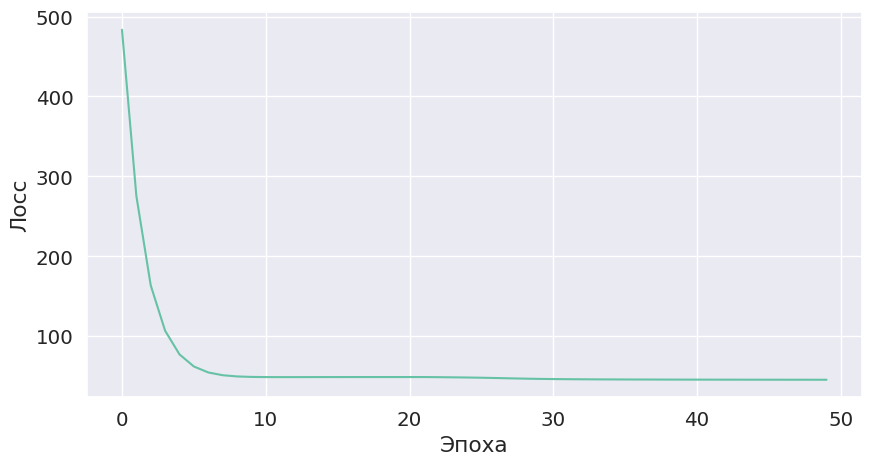

In [ ]:
lstm_model, _ = train_ts_model(
    lstm_model,
    criterion,
    optimizer,
    train_batch_gen,
    num_epochs=50,
)

Сравните скорость обучения RNN со скоростю обучения сверточной сети.

**ваш ответ** RNN обучается дольше, чем свёрточная сеть (по ощущениям раза в 2).

In [ ]:
lstm_model.eval()
start_seq = processed_data_train[-n_past:].to_numpy()
result = evaluate_ts_model(lstm_model, start_seq, processed_data_test)

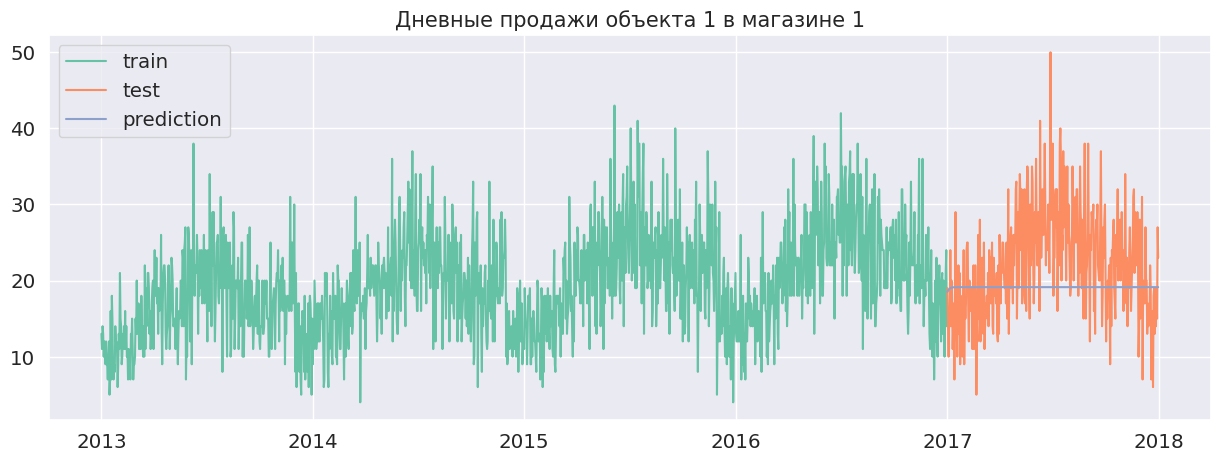

In [ ]:
plot_results(data_train, data_test, result)

In [ ]:
add_results_in_comparison_table('LSTM+data_from_other_stores_last+hidden_state', data_test, result)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.084511,4.175918,0.212206
2,RandomForest+shifted features,25.991229,4.031808,0.195645
3,Conv1d+data_from_other_stores+120_window,49.259769,5.550029,0.271758
4,Conv1d+data_from_other_stores+60_window,60.461322,6.217035,0.290826
5,Conv1d+data_from_other_stores+365_window,48.989193,5.450387,0.271807
6,LSTM+data_from_other_stores_last+hidden_state,57.472095,5.995190,0.283442


На самом деле, внутри RNN используются функции активации типа сигмоиды, которые чувствительны с масштабу и центрированию данных. Попробуем добавить нормализацию данных.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
processed_data_train_normalized = scaler.fit_transform(processed_data_train)

processed_data_train_normalized

array([[-0.53846154, -0.76923077, -0.34782609, ..., -0.64      ,
        -0.70212766, -0.59183673],
       [-0.64102564, -0.61538462, -0.82608696, ..., -0.88      ,
        -0.78723404, -0.59183673],
       [-0.48717949, -0.61538462, -0.73913043, ..., -0.8       ,
        -0.31914894, -0.51020408],
       ...,
       [-0.12820513, -0.26923077, -0.34782609, ..., -0.6       ,
        -0.57446809, -0.14285714],
       [ 0.02564103,  0.03846154, -0.26086957, ..., -0.4       ,
         0.10638298, -0.14285714],
       [-0.48717949, -0.30769231, -0.04347826, ..., -0.4       ,
        -0.06382979, -0.02040816]])

In [ ]:
n_past = 90  # tau -- длина отрезка временого ряда
batch_size = 32  # размер батча

train_dataset = TSDataset(processed_data_train_normalized, n_past)
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)

In [ ]:
lstm_model = LSTM(10, 10, use_pool=False)

criterion = nn.MSELoss()
lr=0.5e-4
optimizer = torch.optim.Adam(params=lstm_model.parameters(), lr=lr)

Эпоха 50 из 50 выполнена за 1.205 сек.
  лосс: 	0.085362


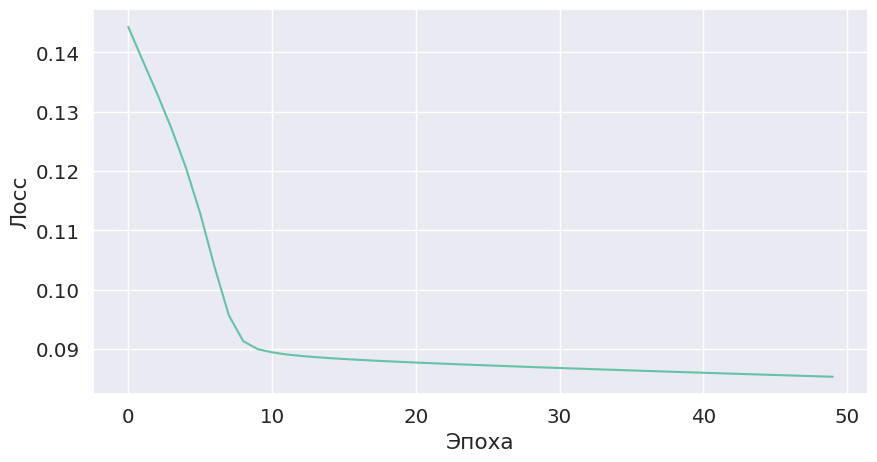

In [ ]:
lstm_model, _ = train_ts_model(
    lstm_model,
    criterion,
    optimizer,
    train_batch_gen,
    num_epochs=50,
)

In [ ]:
lstm_model.eval()
start_seq = processed_data_train_normalized[-n_past:]
result = evaluate_ts_model(lstm_model, start_seq, processed_data_test, return_all=True)

In [ ]:
result.shape

(365, 10)

In [ ]:
result = scaler.inverse_transform(result)[:, 0]

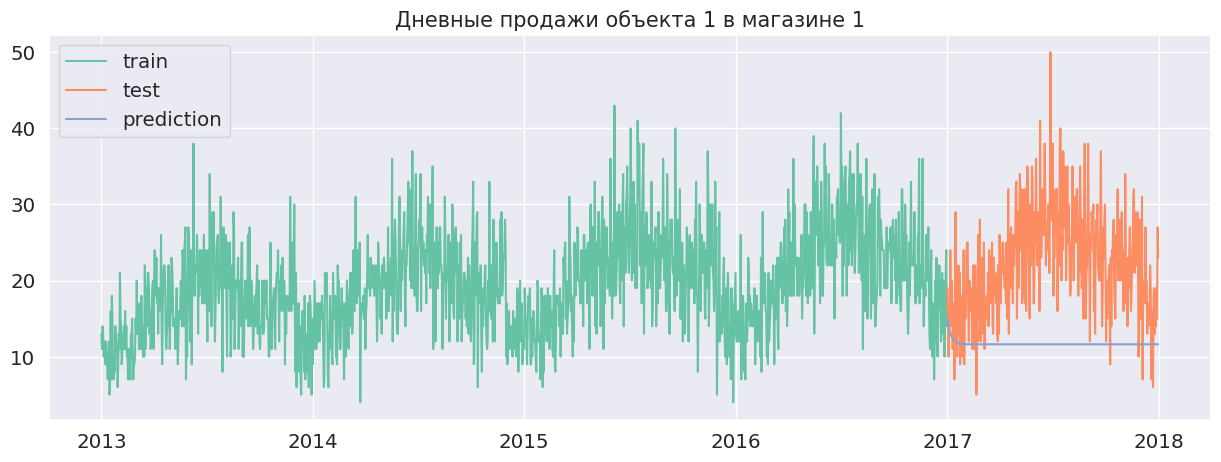

In [ ]:
plot_results(data_train, data_test, result)

In [ ]:
add_results_in_comparison_table('LSTM+data_from_other_stores_last+hidden_state+nolmalized', data_test, result)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.084511,4.175918,0.212206
2,RandomForest+shifted features,25.991229,4.031808,0.195645
3,Conv1d+data_from_other_stores+120_window,49.259769,5.550029,0.271758
4,Conv1d+data_from_other_stores+60_window,60.461322,6.217035,0.290826
5,Conv1d+data_from_other_stores+365_window,48.989193,5.450387,0.271807
6,LSTM+data_from_other_stores_last+hidden_state,57.472095,5.995190,0.283442
7,LSTM+data_from_other_stores_last+hidden_state+...,159.251436,10.754371,0.441823


В начале...

Теперь добавим усреднение всех скрытых состояний.

In [ ]:
n_past = 90  # tau -- длина отрезка временого ряда
batch_size = 32  # размер батча

train_dataset = TSDataset(processed_data_train_normalized, n_past)
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)

In [ ]:
lstm_model = LSTM(10, 10, use_pool=True)

criterion = nn.MSELoss()
lr=0.5e-4
optimizer = torch.optim.Adam(params=lstm_model.parameters(), lr=lr)

Эпоха 50 из 50 выполнена за 1.251 сек.
  лосс: 	0.084786


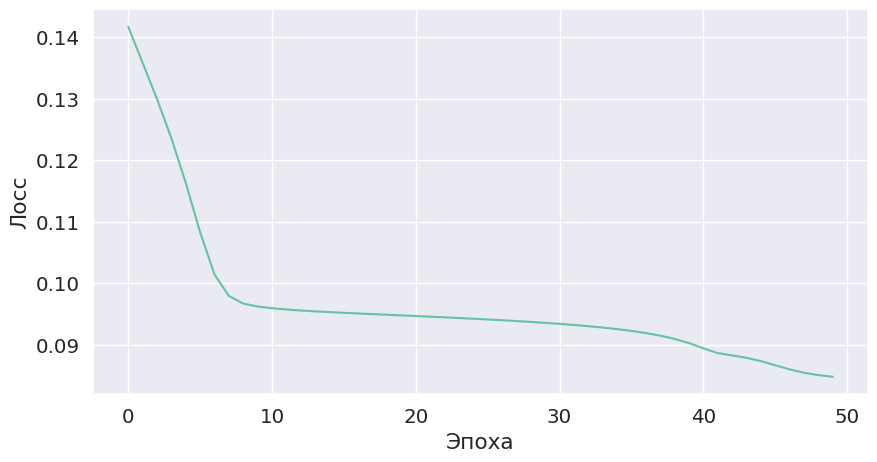

In [ ]:
lstm_model, _ = train_ts_model(
    lstm_model,
    criterion,
    optimizer,
    train_batch_gen,
    num_epochs=50,
)

In [ ]:
lstm_model.eval()
start_seq = processed_data_train_normalized[-n_past:]
result = evaluate_ts_model(lstm_model, start_seq, processed_data_test, return_all=True)
result = scaler.inverse_transform(result)[:, 0]

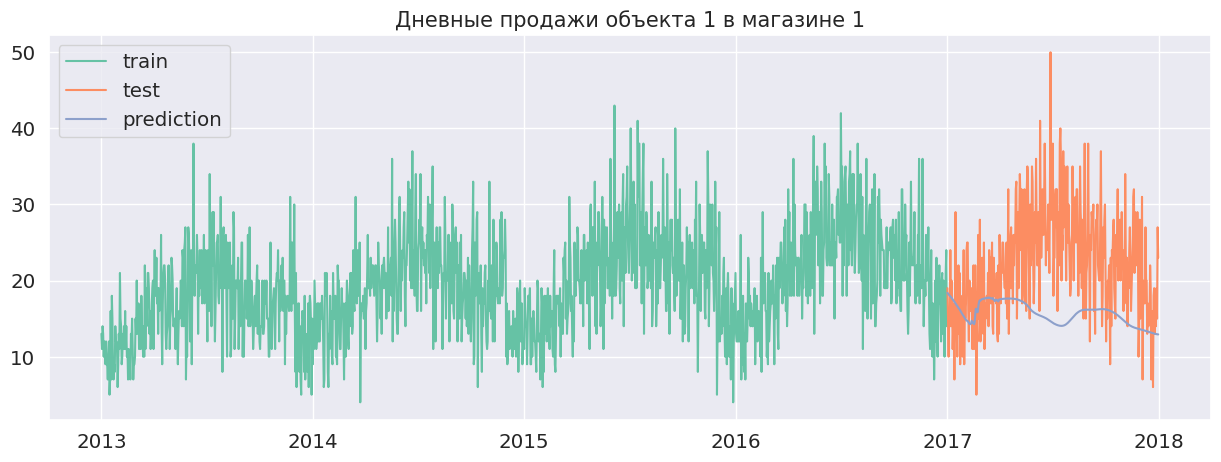

In [ ]:
plot_results(data_train, data_test, result)

In [ ]:
add_results_in_comparison_table('LSTM+data_from_other_stores+mean_hidden_state+normalized', data_test, result)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.084511,4.175918,0.212206
2,RandomForest+shifted features,25.991229,4.031808,0.195645
3,Conv1d+data_from_other_stores+120_window,49.259769,5.550029,0.271758
4,Conv1d+data_from_other_stores+60_window,60.461322,6.217035,0.290826
5,Conv1d+data_from_other_stores+365_window,48.989193,5.450387,0.271807
6,LSTM+data_from_other_stores_last+hidden_state,57.472095,5.995190,0.283442
7,LSTM+data_from_other_stores_last+hidden_state+...,159.251436,10.754371,0.441823
8,LSTM+data_from_other_stores+mean_hidden_state+...,93.748277,7.743850,0.326105


В итоге сеть хотя бы как-то обучилась, но при этом все равно не очень. Такой результат мог получиться сразу по нескольким причинам

1. Вектор для нейросети мог быть выбран неудачно. На самом деле, если посмотреть на корреляции между продажами отдельных магазинов можно увидеть цифры около 0.4, что не так уж и много
2. RNN обычно плохо предсказывают такие шумные данные, как у нас, лучше работают с более плавными зависимостями
3. Последовательность длины 90 для RNN это довольно много, поскольку они подвержены забыванию, усреднение всех скрытых состояний помогает решить эту проблему хотя бы немного
4. Мы использовали RNN для задачи вида $[x_1, \dots, x_t] \to x_{t+1}$, но чаще всего их используют для задачи вида $[x_1, \dots, x_t] \to [x_2, \dots, x_{t+1}]$. В таком случае линейное преобразование применяется к каждому скрытому состоянию и лосс считается по всем векторам вместе (некоторый аналог Inception, но с одними и теми же весами). 
5. Если потюнить параметры, возможно можно получить результат получше

В целом данная задача показывает, что нейронные сети далеко не всегда работают лучше, чем классические модели. По бейзлайну мы видим, что здесь оказались очень важными годовая и недельная периодичность, которые уловить нашим сетями оказалось довольно сложно.

**Теперь сохраним модель**

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/MyModel.pt')

**Загрузим модель**

In [ ]:
LoadModel = torch.load('/content/drive/MyDrive/MyModel.pt')

**Посмотрим, что сохранилось**

In [ ]:
print(LoadModel)

OrderedDict([('conv1.weight', tensor([[[-0.1048, -0.0524,  0.0122,  ..., -0.0412, -0.0662,  0.0403],
         [-0.0387,  0.0227, -0.0589,  ..., -0.0428,  0.0439, -0.0568],
         [ 0.0593, -0.0782, -0.0097,  ..., -0.0864, -0.0335,  0.0178],
         ...,
         [ 0.0208,  0.0166,  0.0101,  ..., -0.0156, -0.0218,  0.0215],
         [-0.0260, -0.0212, -0.0438,  ..., -0.0056,  0.0223,  0.0218],
         [-0.0514, -0.0761, -0.0397,  ...,  0.0009, -0.0507, -0.0220]],

        [[ 0.0136, -0.0183, -0.1289,  ...,  0.0348,  0.0048,  0.0015],
         [ 0.0075,  0.0277,  0.0147,  ...,  0.1043, -0.0593,  0.0014],
         [ 0.0332, -0.0962, -0.0492,  ...,  0.0600, -0.0783, -0.0170],
         ...,
         [-0.0236,  0.0622, -0.0104,  ...,  0.0429, -0.0483, -0.0564],
         [ 0.0661,  0.0141,  0.0193,  ..., -0.0255,  0.0200, -0.0360],
         [-0.0143,  0.0062, -0.0213,  ...,  0.0071,  0.0416, -0.0229]],

        [[ 0.0430,  0.0273,  0.0292,  ..., -0.0180, -0.0023, -0.0034],
         [ 0.05

Сохранение модели таким образом сохранит весь модуль, используя модуль pickle в Python. 

Недостатком этого подхода является то, что сериализованные данные привязаны к конкретным классам и точной структуре каталогов, используемой при сохранении модели. Причина этого заключается в том, что pickle не сохраняет сам класс модели. Скорее всего, он сохраняет путь к файлу, содержащему класс, который используется во время загрузки. Из-за этого наш код может по-разному ломаться при использовании в других проектах или после рефакторинга.

In [ ]:
import time
def save(file_name):
    def decor(func):
        def wrapper(*args, **kwargs):
            start=time.time()
            with open(file_name, 'a') as f:
              f.write( 'start at ' + time.ctime() + '\n')
            res=func(*args, **kwargs)
            res_time=time.time()-start
            with open(file_name, 'a') as f:
              f.write(str(res) + '\n' + str(res_time) + '\n')

            return res, res_time
        return wrapper
    return decor

@save('Decor.txt')
def sum(a, b, c):
    s = 0
    for i in range (c):
        s += (a+b)*c
    return s

In [ ]:
sum(2, 3, 10000)

(500000000, 0.012389659881591797)